In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [16]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5,outlier_k=.0625)
df.groupby('outliers').agg('count')
train, validate, test = w.tvt_split(df)
train.shape

(43320, 36)

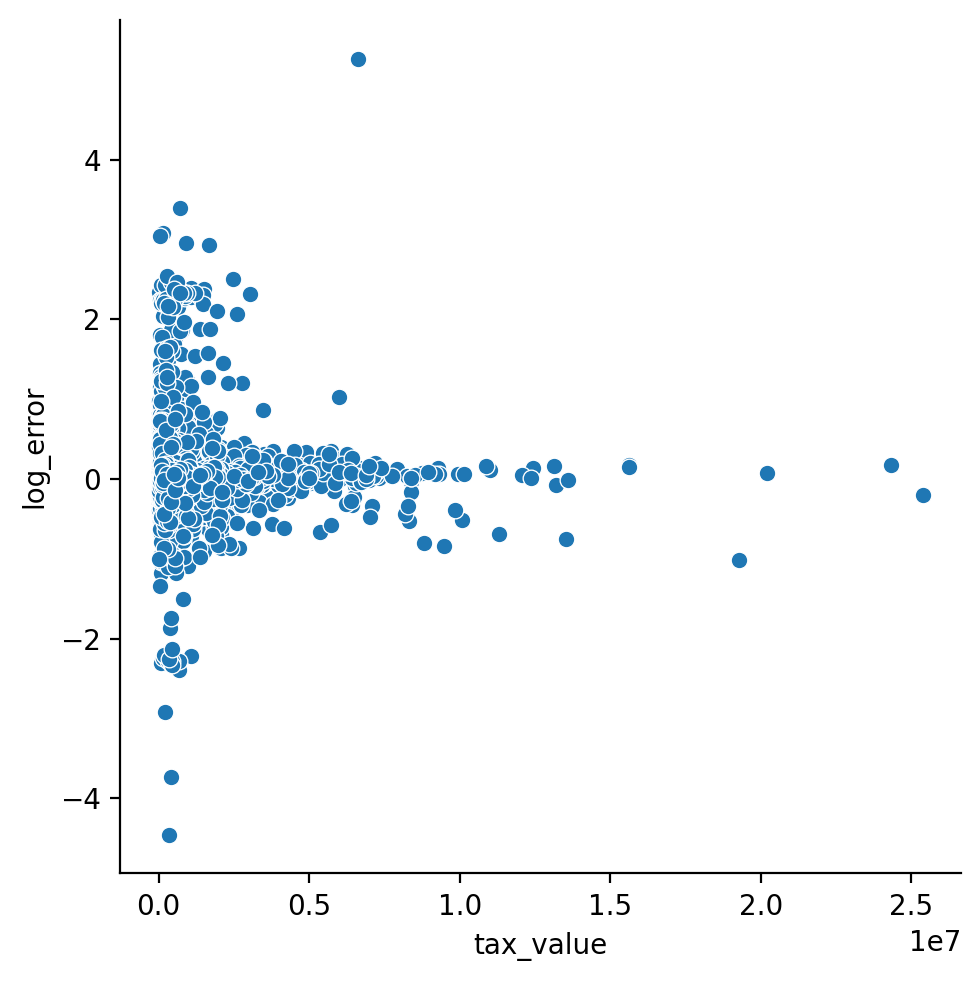

In [69]:

sns.relplot(data=train, x='tax_value', y='log_error')

In [30]:
train.outliers.cat.categories

Index(['in_range', 'lower', 'upper'], dtype='object')

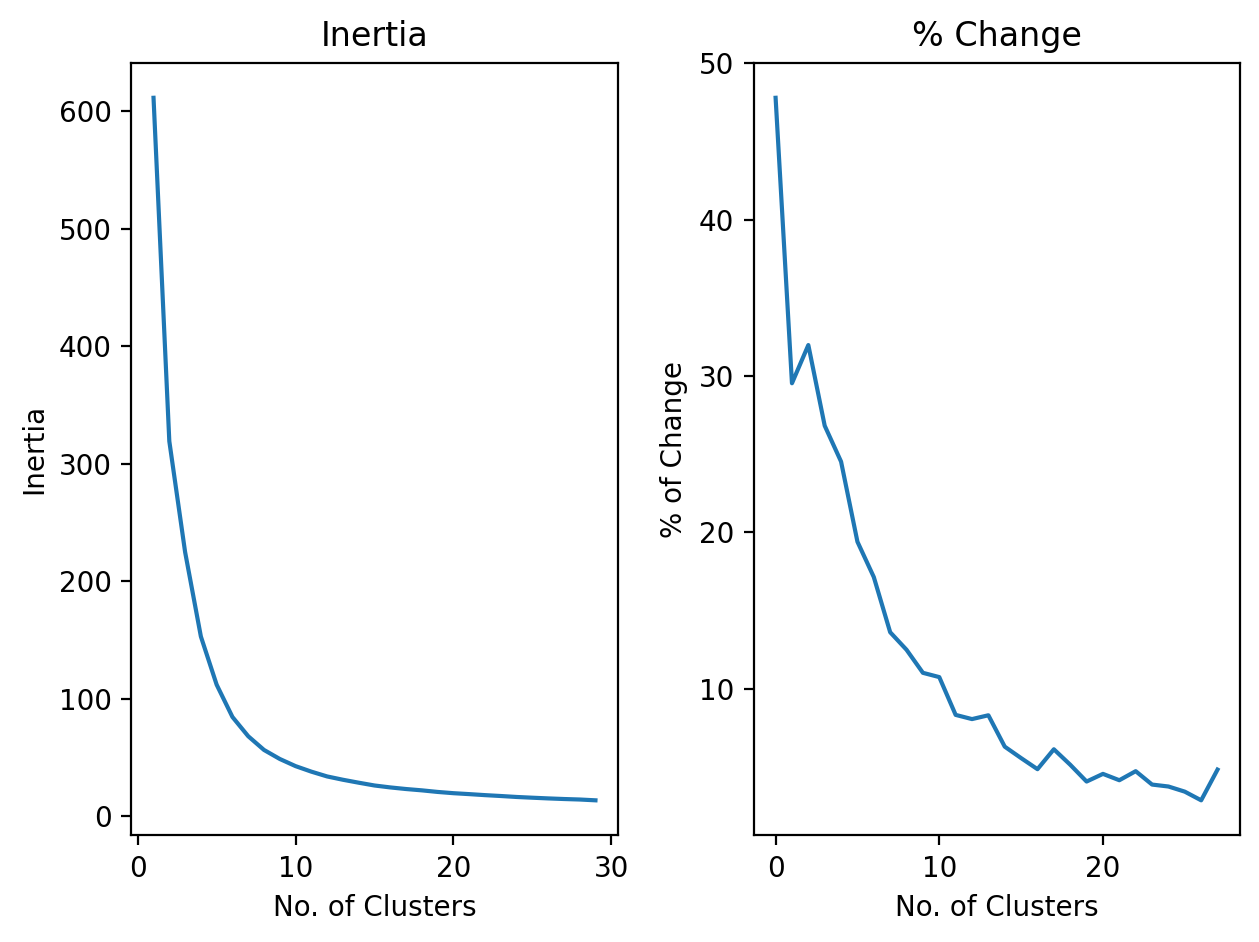

in       42636
above      483
below      201
Name: bound_group, dtype: int64

In [32]:
reload(e)
lower_tudes = w.scale(train[train.outliers == 'lower'],['latitude','longitude'])
e.generate_elbow(lower_tudes,k_min=1,k_max=30)
train.bound_group.value_counts()

(35493, 36)

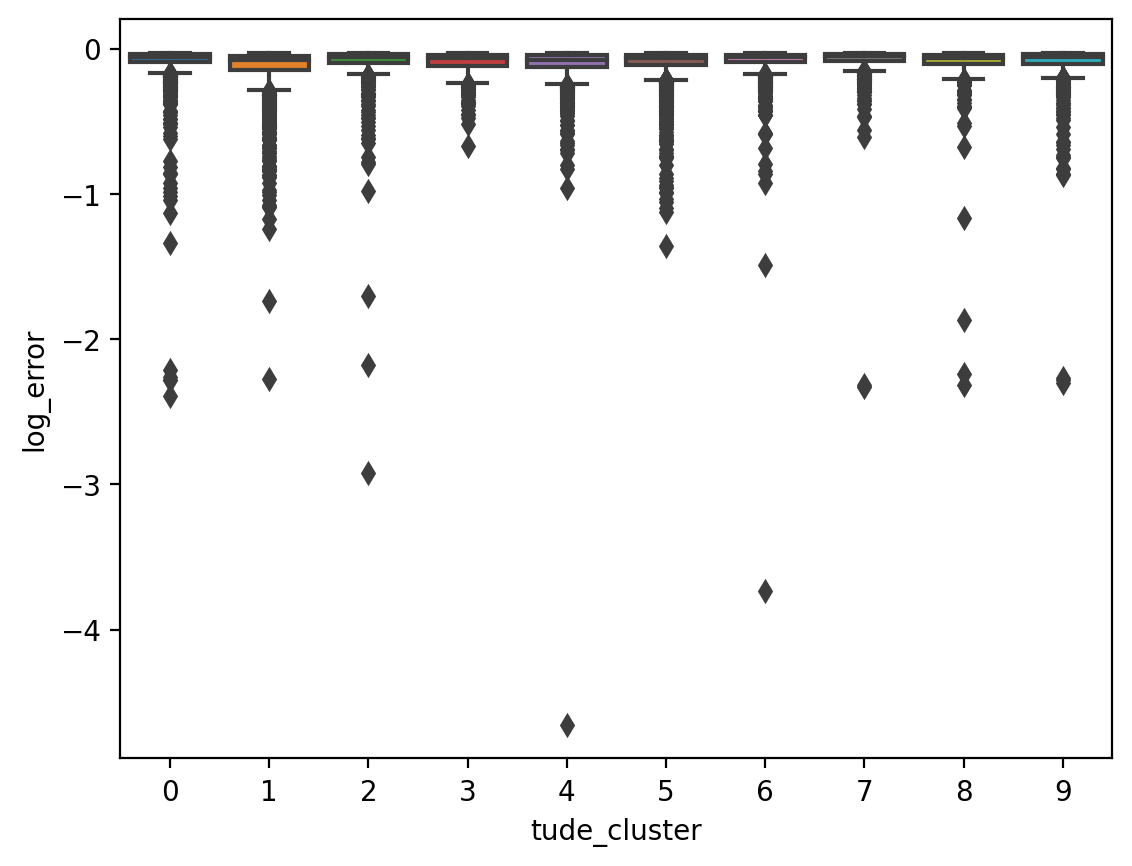

In [33]:
kmeans = KMeans(10)
kmeans.fit(lower_tudes)
lower_tudes['tude_cluster'] = kmeans.predict(lower_tudes)
lower_tudes['log_error'] = train[train.outliers !='in_range'].log_error
sns.boxplot(data=lower_tudes,y='log_error',x='tude_cluster')
df[df.outliers != 'in_range'].shape

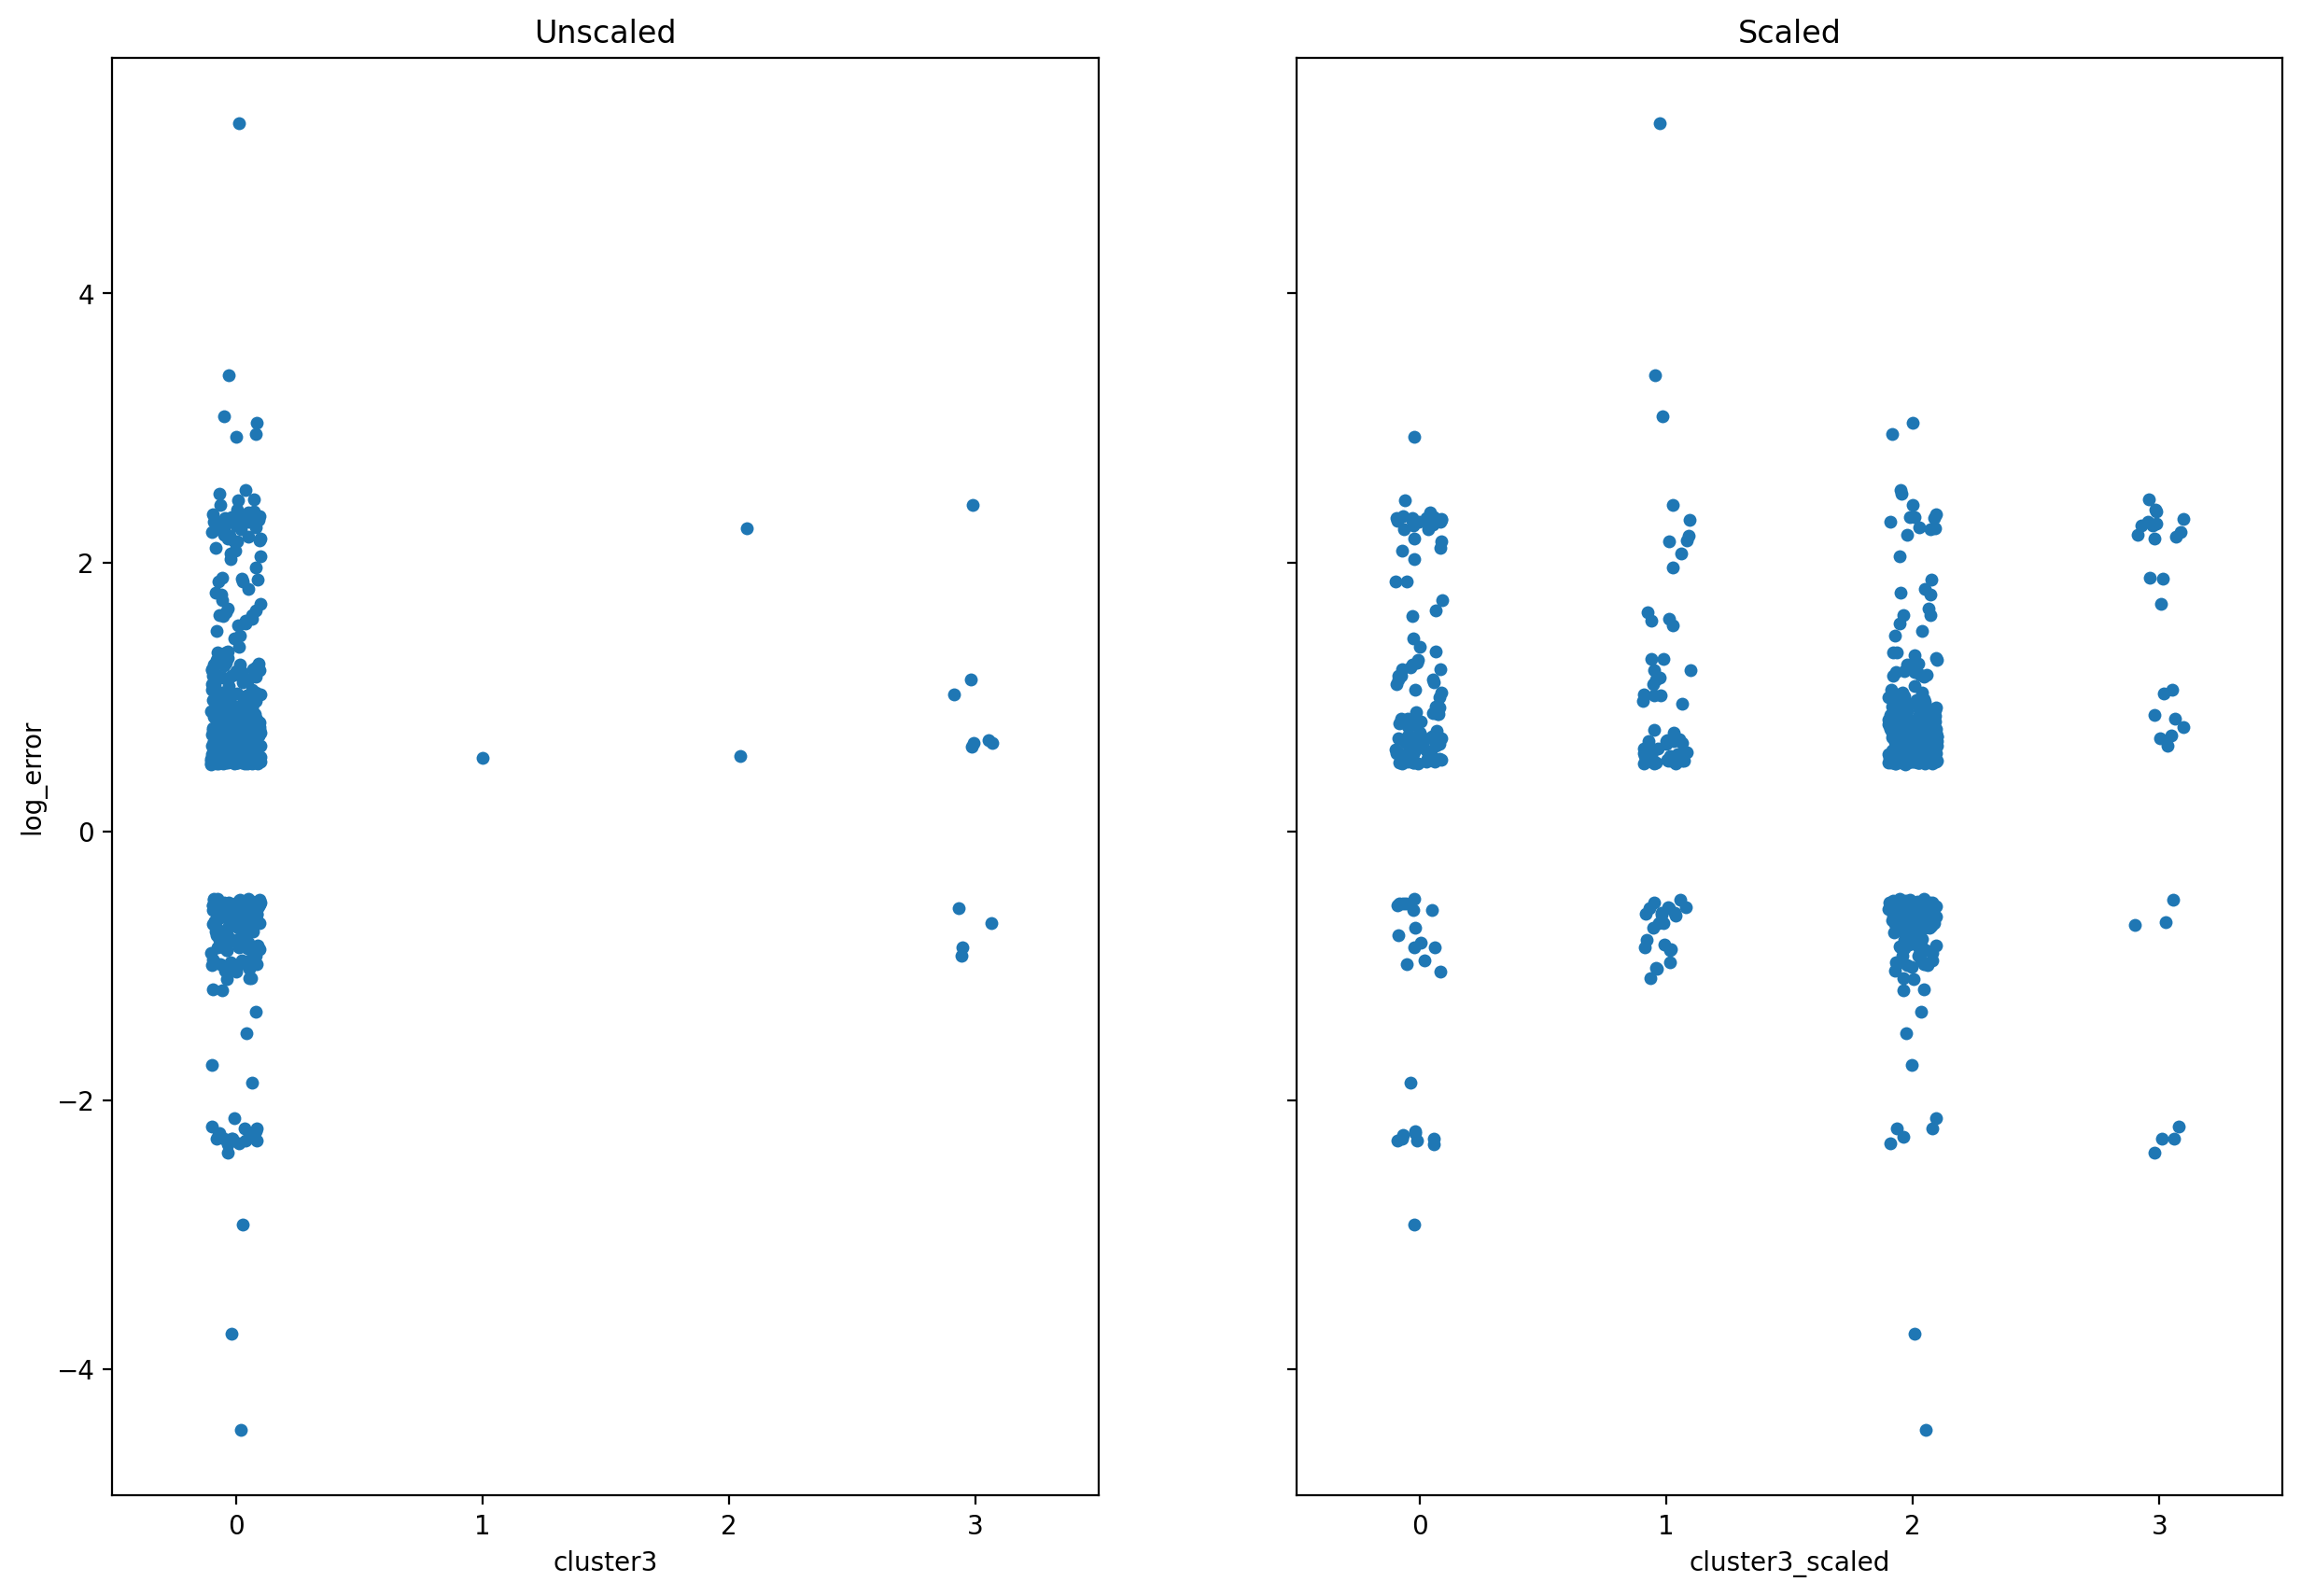

In [83]:
reload(e)
bound = .5
bound_train = train[(train.log_error > bound) | (train.log_error < (0-bound))]
e.viz_for_Q3(bound_train)